In [1]:
!pip install "dask[complete]"
!pip install pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [2]:
!pip install tensorflow
!pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mse
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization
from sklearn.metrics import recall_score, precision_score,accuracy_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Layer


In [ ]:
# 1. Load Data from Parquet Files
data_dir = '/content/drive/MyDrive/Data_hasking'
# Get a list of all parquet files (first 40 days) and load them into a Dask DataFrame
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))[:40]
ddf = dd.read_parquet(file_list)

In [ ]:
# 2. Load Customer Data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()


# Filter individual customers (CUSTOMER_TYPE == 'Cá nhân')
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()

In [ ]:
# 3. Filter Transactions for Individual Customers
ddf_filtered = ddf[['CUST_CUSTNO', 'AMOUNT',  'VALUEDATE']]
df_individual = ddf_filtered[ddf_filtered['CUST_CUSTNO'].isin(individual_customers)]
df_individual_df = df_individual.compute()


In [ ]:
df_individual_df

In [ ]:
# 4. Convert VALUEDATE to Datetime and Extract Date
df_individual_df['VALUEDATE'] = pd.to_datetime(df_individual_df['VALUEDATE'], errors='coerce')
df_individual_df['DATE_ONLY'] = df_individual_df['VALUEDATE'].dt.date

In [ ]:
# 5. Separate Deposits and Withdrawals
df_deposits = df_individual_df[df_individual_df['AMOUNT'] > 0]
df_withdrawals = df_individual_df[df_individual_df['AMOUNT'] < 0]

In [ ]:
# 6. Aggregate by Customer and Date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')

In [ ]:
# 7. Merge Deposits and Withdrawals Data
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)

#1. Data Preparation (Log Transformations)

In [ ]:
# 8. Log Transform the Data
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())

In [ ]:
# Prepare the data for anomaly detection
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
print(f"Original input dimension: {features_scaled.shape}")


#2. VAE for Local Patterns

Epoch 1/100
10773/10773 [==============================] - 68s 6ms/step - loss: 1.0116 - val_loss: 0.9572
Epoch 2/100
10773/10773 [==============================] - 67s 6ms/step - loss: 1.0060 - val_loss: 0.9795
Epoch 3/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9963 - val_loss: 0.9864
Epoch 4/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9931 - val_loss: 0.9922
Epoch 5/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9931 - val_loss: 0.9917
Epoch 6/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9929 - val_loss: 0.9793
Epoch 7/100
10773/10773 [==============================] - 67s 6ms/step - loss: 0.9929 - val_loss: 0.9796
Epoch 8/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9925 - val_loss: 0.9758
Epoch 9/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9928 - val_loss: 0.9749
Epoch 10/100
10773/10773 [====================

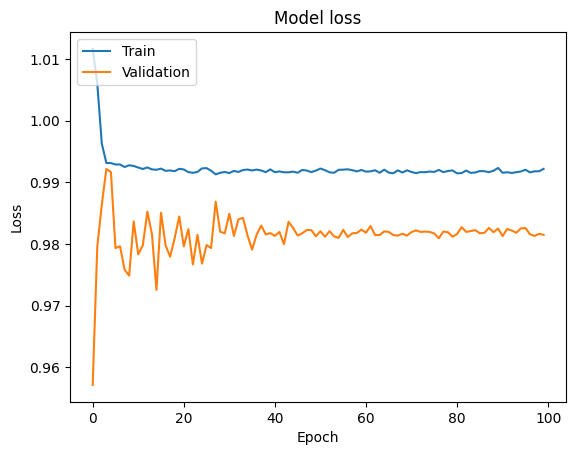

In [ ]:
# Adjust latent dimension, batch size, learning rate, and epochs
latent_dim = 128  # Increased latent space dimension for better feature capture
batch_size = 512  # Reduced batch size to allow better generalization
epochs = 100  # Increased epochs for better convergence

# Build the Encoder model
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    h = layers.Dense(128, activation=None)(inputs)  # No activation, we'll add LeakyReLU
    h = layers.LeakyReLU(alpha=0.1)(h)  # LeakyReLU for better gradient flow
    h = layers.Dropout(0.2)(h)  # Dropout for regularization
    h = layers.Dense(64, activation=None)(h)
    h = layers.LeakyReLU(alpha=0.1)(h)
    h = layers.Dropout(0.2)(h)
    z_mean = layers.Dense(latent_dim)(h)
    z_log_var = layers.Dense(latent_dim)(h)
    return Model(inputs, [z_mean, z_log_var])

# Build the Decoder model
def build_decoder(output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation=None)(latent_inputs)
    h = layers.LeakyReLU(alpha=0.1)(h)
    h = layers.Dense(128, activation=None)(h)
    h = layers.LeakyReLU(alpha=0.1)(h)
    outputs = layers.Dense(output_dim)(h)
    return Model(latent_inputs, outputs)

# Sampling layer to sample from latent space
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Loss Function
def vae_loss(inputs, reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed), axis=-1)  # MSE loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)  # KL divergence
    return reconstruction_loss + kl_loss

# Build the VAE model
def build_vae(encoder, decoder):
    inputs = layers.Input(shape=(2,))  # Input for 2 features: log_total_deposits, log_total_withdrawals
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    reconstructed = decoder(z)
    vae = Model(inputs, reconstructed)
    vae.add_loss(vae_loss(inputs, reconstructed, z_mean, z_log_var))  # Add VAE loss
    return vae

# Create the VAE model
encoder = build_encoder(2)
decoder = build_decoder(2)
vae = build_vae(encoder, decoder)

# Compile the VAE with the Adam optimizer and a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)  # Reduce learning rate over time

vae.compile(optimizer=Adam(learning_rate=lr_schedule))

# Train the VAE
history = vae.fit(features_scaled, features_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:

# Get the reconstructed data
reconstructed_data = vae.predict(features_scaled)
# Calculate the reconstruction error (MSE)
reconstruction_error = np.mean(np.square(features_scaled - reconstructed_data), axis=1)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
# Set threshold as mean + 2 * standard deviation
threshold = mean_error + 2 * std_error
print(f'Threshold: {threshold}')
# Identify anomalies
anomalies = reconstruction_error > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')


191509/191509 [==============================] - 304s 2ms/step
Threshold: 2.1996935187440503
Number of anomalies detected: 261781


In [ ]:
# Rule-based anomalies
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals
612,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,-10051700.46,16.163963,16.123252
618,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,-7513252.10,15.786710,15.832179
3876,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,11236003.08,-12497903.80,16.234634,16.341072
5343,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7162326.10,-7162163.01,15.784346,15.784323
5345,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6172231.88,-6342641.09,15.635571,15.662806
...,...,...,...,...,...,...
4091570,ffa1f3b742233373eedaf14f21c5c2833beed4b44eb6f3...,2023-08-29,27950000.05,-40949450.00,17.145928,17.527849
4092093,ffabda738508e4c6a75e696549413207707ac1366d57a8...,2023-08-11,6474800.00,-6316800.00,15.683428,15.658723
4095791,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,-6231263.79,15.646921,15.645090
4096302,fff5865d6fd5d7a5893f904b1cb18479fa79ea3b09c4b3...,2023-08-07,9435971.82,-9437298.90,16.060040,16.060180


**Mean + Standard Deviation Method**

In [ ]:
# Convert boolean array to indices of anomalies detected by VAE
vae_anomaly_indices = np.where(anomalies)[0]

# Convert DataFrame to indices of anomalies detected by rule 15
rule_15_anomaly_indices = transactions.index[transactions.index.isin(rule_15_anomalies.index)].tolist()

# Find the intersection of the two sets of indices
intersection_indices = set(vae_anomaly_indices) & set(rule_15_anomaly_indices)

# Print the number of intersecting anomalies
print(f"Number of anomalies detected by both VAE and rule 15: {len(intersection_indices)}")



Number of anomalies detected by both VAE and rule 15: 3654


In [ ]:
y_true = transactions.index.isin(rule_15_anomalies.index)  # Ground truth
y_pred = anomalies  # Predicted anomalies from VAE

# Calculate recall and precision
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


Recall: 0.718442784113252
Precision: 0.013958232262845661
Accuracy: 0.9576456808332913


**Statistical Approach: Percentile-Based Threshold**

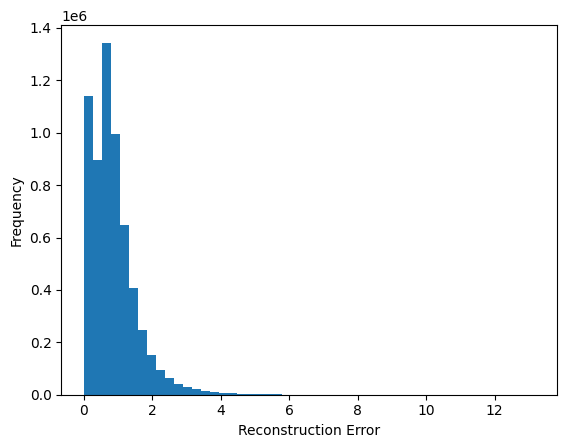

In [ ]:
# Plot the reconstruction error
plt.hist(reconstruction_error, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Calculate reconstruction error for each data point
reconstructed_data = vae.predict(features_scaled)
reconstruction_error = np.mean(np.square(features_scaled - reconstructed_data), axis=1)

# Set threshold based on the 95th percentile of reconstruction error
threshold = np.percentile(reconstruction_error, 95)
print(f'Threshold: {threshold}')

# Identify anomalies
anomalies_identified = reconstruction_error > threshold
print(f'Number of anomalies detected: {np.sum(anomalies_identified)}')


191509/191509 [==============================] - 317s 2ms/step
Threshold: 2.09368419100107
Number of anomalies detected: 306414


In [ ]:

# Convert boolean array to indices of anomalies detected by VAE
vae_anomaly_indices = np.where(anomalies_identified)[0]

# Convert DataFrame to indices of anomalies detected by rule 15
rule_15_anomaly_indices = transactions.index[transactions.index.isin(rule_15_anomalies.index)].tolist()

# Find the intersection of the two sets of indices
intersection_indices = set(vae_anomaly_indices) & set(rule_15_anomaly_indices)

# Print the number of intersecting anomalies
print(f"Number of anomalies detected by both VAE and rule 15: {len(intersection_indices)}")

# You can also access the actual transactions that are considered anomalies by both methods:
common_anomalies = transactions.iloc[list(intersection_indices)]
print("Common anomalies detected by VAE and rule 15:")
print(len(common_anomalies))


Number of anomalies detected by both VAE and rule 15: 3747
Common anomalies detected by VAE and rule 15:
3747


In [ ]:
y_True = transactions.index.isin(rule_15_anomalies.index)  # Ground truth
y_Pred = anomalies_identified  # Predicted anomalies from VAE

# Calculate recall and precision
recall = recall_score(y_True, y_Pred)
precision = precision_score(y_True, y_Pred)

print(f"Recall: {recall}")
print(f"Precision: {precision}")

accuracy = accuracy_score(y_True, y_Pred)
print(f"Accuracy: {accuracy}")


Recall: 0.7367282736924892
Precision: 0.012228553525622198
Accuracy: 0.9503929081534663
